In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import FunctionTransformer
from sklearn.pipeline import Pipeline


plt.style.use("seaborn-v0_8")
random_state = 42

---
# k - Nearest Neighbors [(doc)](https://scikit-learn.org/stable/modules/neighbors.html#)
- The main idea is that samples that have similar features tend to have similar labels.
0. Normalize the values of each attribute. It prevents attributes with large ranges from outweighing attributes with smaller ranges
1. Choose a distance metric, for comparing the unlabeled (test) sample with the training samples (Euclidean, Manhattan, ...)
2. The Nearest Neighbors identify the “neighbors” of the unlabeled (test) sample. The neighbors can be defined as the $k$ nearest (train) samples, using the chosen distance metric, defining decision regions.
    - Or as the examples inside a sphere of a given radius centered around the unlabeled example. The other method generally works better, for example when dealing with datasets with high variability in their example density.
3. The Nearest Neighbors chooses the most frequent class among these neighbors and assigns it to the unlabeled sample.

- This method can be seen as a sort of moving average, or smoothing, which interpolates between the training data. 
- There is not really a learning procedure (no model fit, only hyperparameters can be learned) and the resulting model has to store all the training data in order to make predictions (lazy learning). One advantage of this is that the training phase is very fast. On the other hand, the resulting model is memory intensive since all training examples have to be stored, and predictions can be slow if the dataset is large.
- For classification problem with k=1, the boundaries show a lot of variations, which makes sense since every example defines its own small prediction region around it, probably overfitting.
- This procedure can also be adapted to the Regression task, by averaging the values of the neighbors. (KNeighborsRegressor)

In [19]:
df = pd.read_csv("datasets/iris.data.txt")
df_X = df.iloc[:, [0, 3]]
encoder = LabelEncoder()
df_Y = encoder.fit_transform(df["Class"])

X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_Y, test_size=0.33, random_state=random_state
)

ParamGrid length: 784


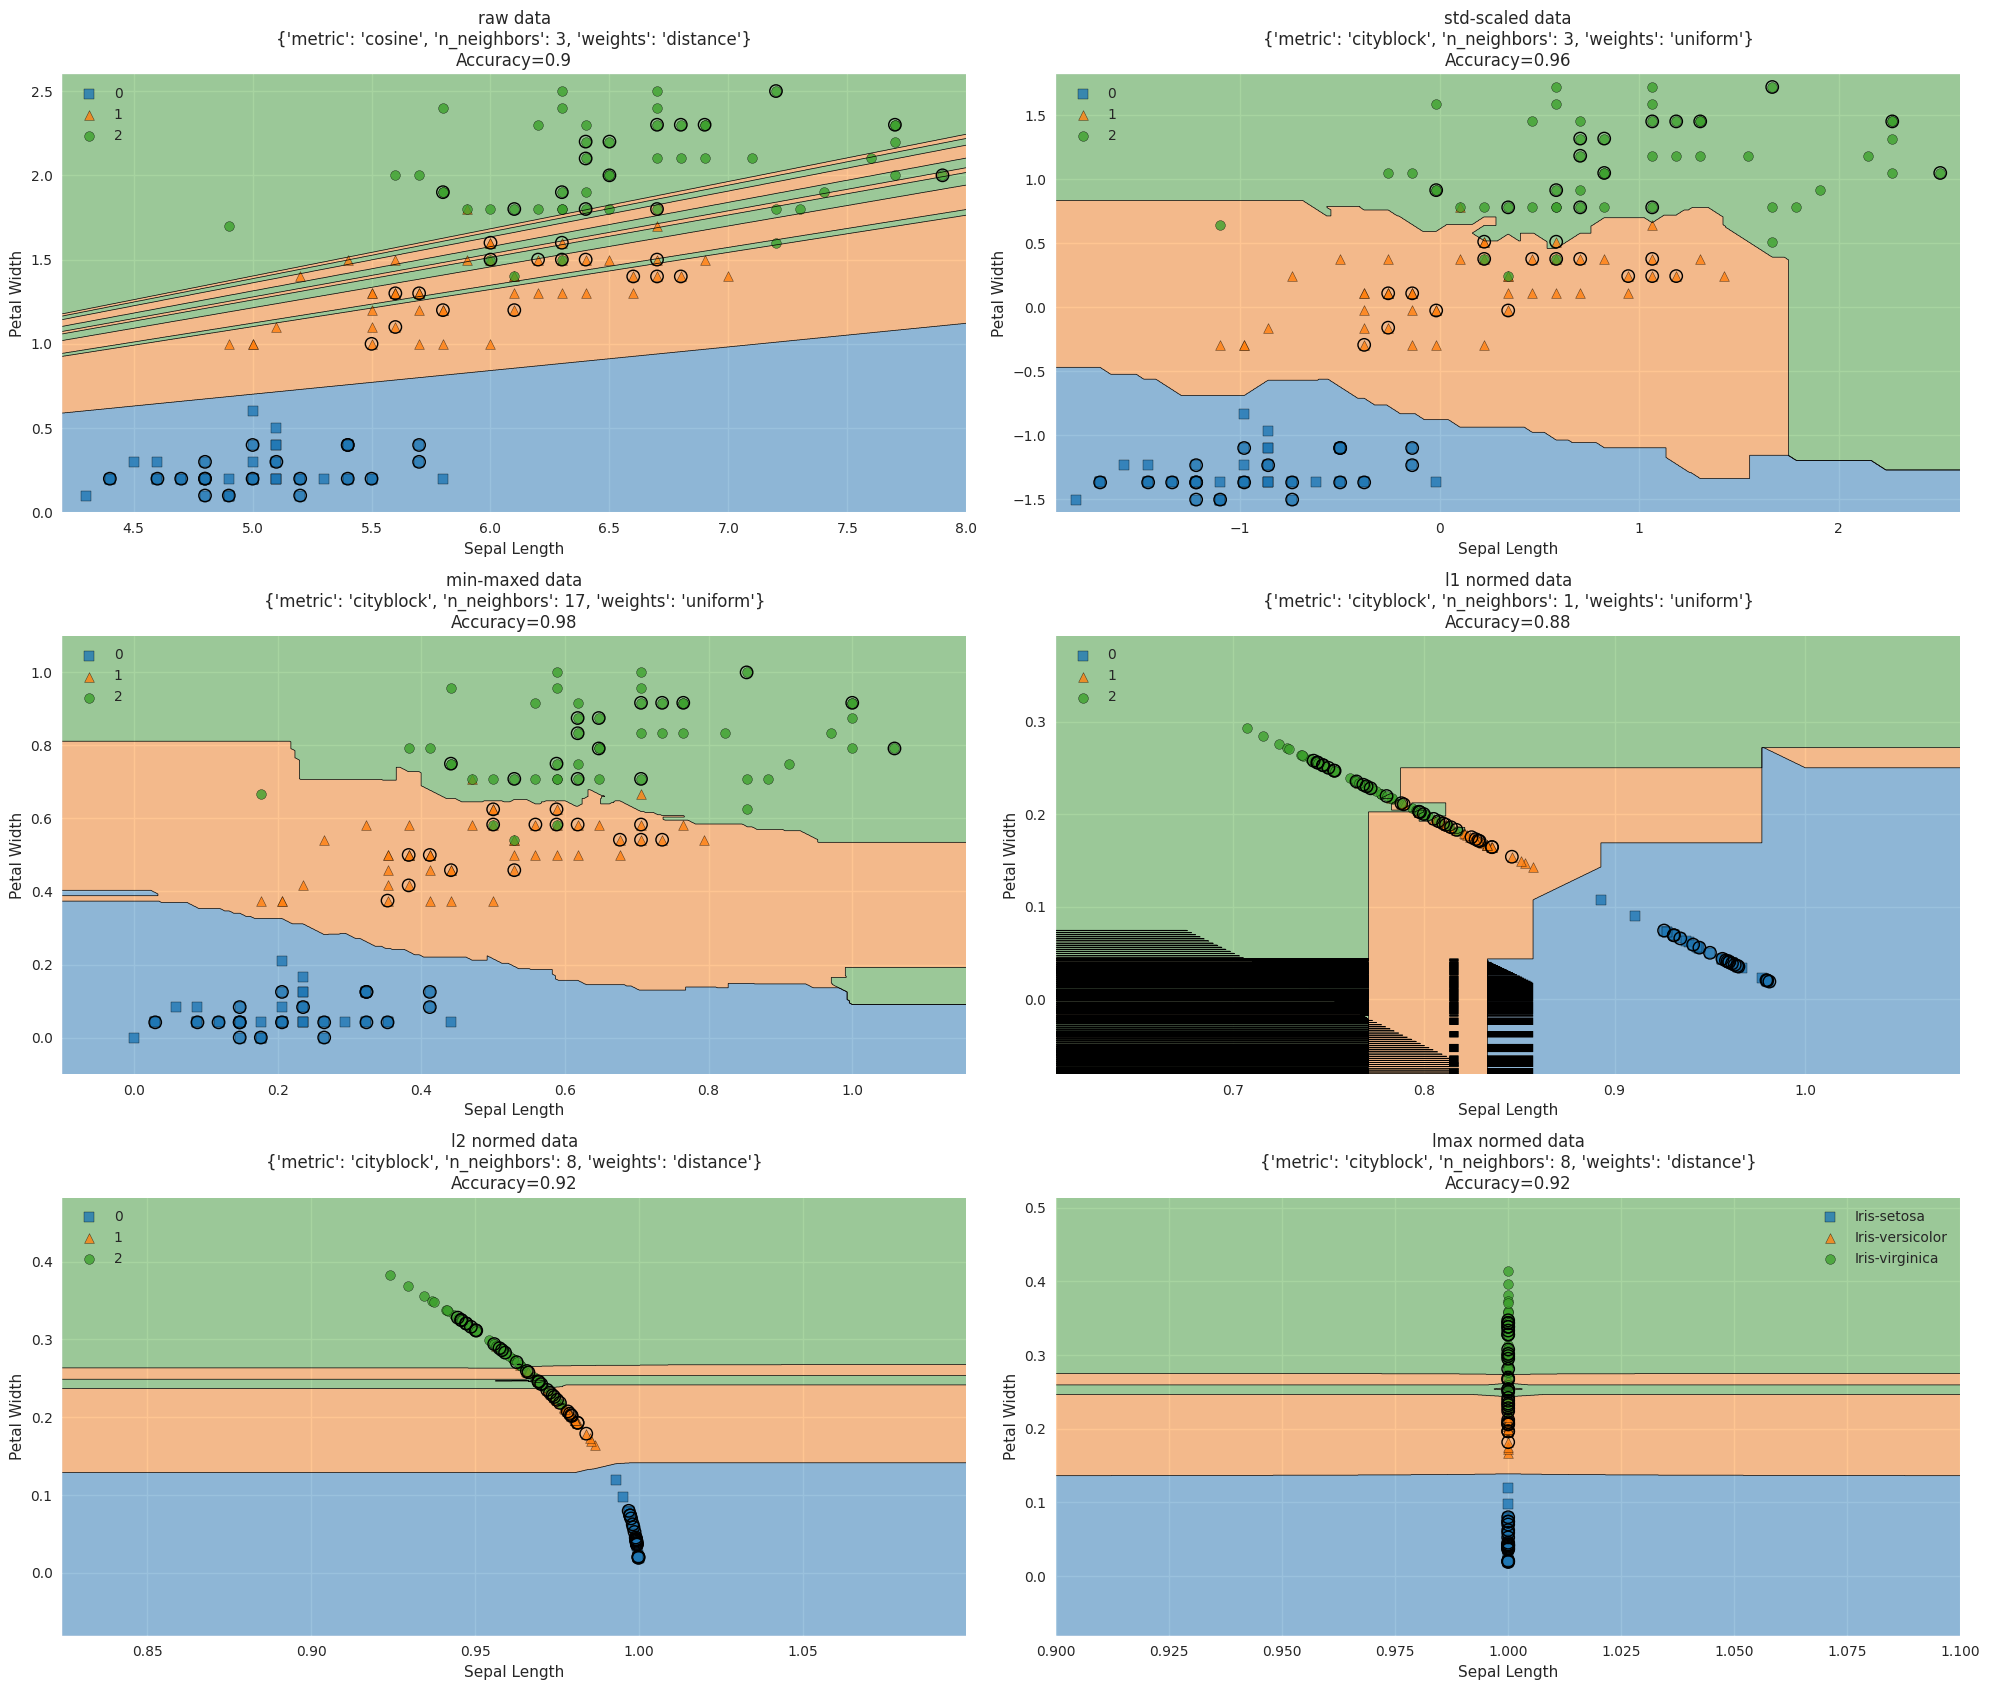

In [20]:
param_grid = {
    "weights": ["uniform", "distance"],
    "metric": [
        "cityblock",
        "cosine",
        "euclidean",
        "haversine",
        "l1",
        "l2",
        "manhattan",
        "nan_euclidean",
    ],
    "n_neighbors": [*range(1, X_test.shape[0])],
}

# ParamGrid Length
print("ParamGrid length: {}".format(len(list(ParameterGrid(param_grid)))))

_, axes = plt.subplots(3, 2, figsize=(20, 17))

# For every preprocess modality
for i, (name, preprocessor) in enumerate(
    [
        (
            "raw",
            FunctionTransformer(lambda x: x, validate=False),
        ),  # does nothing to the data
        ("std-scaled", preprocessing.StandardScaler()),
        ("min-maxed", preprocessing.MinMaxScaler()),
        ("l1 normed", preprocessing.Normalizer(norm="l1")),
        ("l2 normed", preprocessing.Normalizer(norm="l2")),
        ("lmax normed", preprocessing.Normalizer(norm="max")),
    ]
):
    gs = Pipeline(
        [
            (name, preprocessor),
            (
                "search",
                GridSearchCV(
                    KNeighborsClassifier(),
                    param_grid=param_grid,
                    n_jobs=-1,
                    cv=5,
                    # verbose=3,
                ),
            ),
        ]
    )

    # Fit
    gs.fit(X_train.values, y_train)

    # In this case the plot is a bit different: I manually composed the pipeline, inserting the preprocessed data as "X" and "X_highlight", and the estimator as "clf"
    plot_decision_regions(
        preprocessor.fit(X_train.values).transform(df_X.values),
        df_Y,
        clf=gs[1],
        legend=2,
        X_highlight=preprocessor.fit(X_train.values).transform(X_test.values),
        n_jobs=-1,
        zoom_factor=10,
        ax=axes[i // 2, i % 2],
    )
    axes[i // 2, i % 2].set_xlabel(df_X.columns[0])
    axes[i // 2, i % 2].set_ylabel(df_X.columns[1])
    plt.legend(encoder.classes_)
    axes[i // 2, i % 2].set_title(
        "{} data\n{}\nAccuracy={}".format(
            gs.steps[0][0],
            gs.steps[1][1].best_params_,
            gs.score(X_test.values, y_test),
        )
    )
plt.tight_layout()
plt.show()